# Scaling the 2d Acoustic Wave Equation

## Unscaled version

2d Acoustic Wave Equation: $\frac{\partial^2 P}{\partial t^2} = c^2 \nabla^2 P + s(x, z, t)$

Where $ P \equiv P(x, z, t) $ and $ s(x, z, t) $ is a source term

In [33]:
# import dependencies 
import devito as dv
import numpy as np
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

# Initial grid: 2km x 2km, with spacing 100m
extent = (2000., 2000.)
shape = (200, 200)
x = dv.SpaceDimension(name='x', spacing=dv.Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = dv.SpaceDimension(name='z', spacing=dv.Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# setting up velocity field with a layered model
constant_vp = 3
vp = dv.Function(name='vp', grid=grid)
vp.data[:, :100] = 2.5  # layer 1: 2.5km/s
vp.data[:, 100:] = 3.5  # layer 2: 3.5km/s

# calculating timestep with 2d CFL condition, max V_p being the max given above, and dx=100
# played around with tn to get different output images - wave hits the edge of the grid around tn=400
t0, tn = 0., 250.
# commented out, this extracts max from spatially varying field
#c = float(vp.data.max())
c = constant_vp
dt = 0.1/(np.sqrt(2)*c)
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# creating pressure field
p = dv.TimeFunction(name='p', grid=grid, space_order=2, time_order=2)

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)

# defining pde and creating stencil
pde = p.dt2 - constant_vp**2*p.laplace
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))

# set up operator
op = dv.Operator([stencil] + src_p)

# call operator to propagate source
op(time=src.time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.20 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.19409299999998203, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.000311000000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

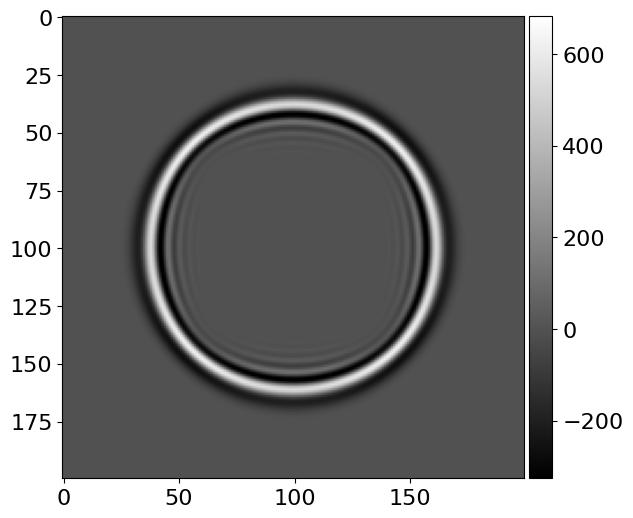

In [34]:
# visualise output
from examples.seismic import plot_image

plot_image(p.data[0])

## Scaled version

Transformed 2d acoustic wave equation: $\frac{\partial^2 P'}{\partial t^2} = c^2 \nabla^2 P' + \frac{s(x, z, t)}{\alpha}$

Where $ P'(x, z, t) \equiv \frac{P(x, z, t)}{\alpha} $ where $ \alpha $ is a scaling factor that reduces the source term injection between -1 and 1. To reduce the source term to the desired size, $ \alpha $ is defined as the maximum amplitude of the source term increased by 5% (this increase was chosen arbitrarily). The steps of the transformation are as follows.

Re-arranging $ P'(x, z, t) \equiv \frac{P(x, z, t)}{\alpha} $ for $ P(x, z, t) $ and substituting into the 2d acoustic wave equation yields:

$ \alpha \frac{\partial^2 P'}{\partial t^2} = \alpha c^2 \nabla^2 P' + \alpha s(x, z, t)$

Dividing through by $ \alpha $ leads to our transformed equation:
$\frac{\partial^2 P'}{\partial t^2} = c^2 \nabla^2 P' + \frac{s(x, z, t)}{\alpha}$


In [35]:
# using same grid, time range, source set up and velocity as above

# redefine pressure field, pde and stencil, source term injection, set up new operator

# scaled pressure field
p_scaled = dv.TimeFunction(name='ps', grid=grid, space_order=2, time_order=2)

# defining scaling factors
# maximum pressure of simulation is 1 (corresponds with source term)
# finding max amplitude of the source term
# this can form the basis of a scaling factor (i.e. scaling the source injection to be less than 1)
src_data = src.data
max_src = round(float(src_data.max()), 3)
alpha = 1.05*max_src

# redefining pde and stencil
pde_transform = p_scaled.dt2 - constant_vp**2*p_scaled.laplace
stencil_transform = dv.Eq(p_scaled.forward, dv.solve(pde_transform, p_scaled.forward))

# redefining source term injection
src_scaled = src.inject(field=p_scaled.forward, expr=src/alpha)

# new operator
op_scaled = dv.Operator([stencil_transform] + src_scaled)

# calling operator
op_scaled(time=src.time_range.num-1, dt=dt)

# rescaling output
p_scaled.data[:] *= alpha

Operator `Kernel` ran in 0.18 s


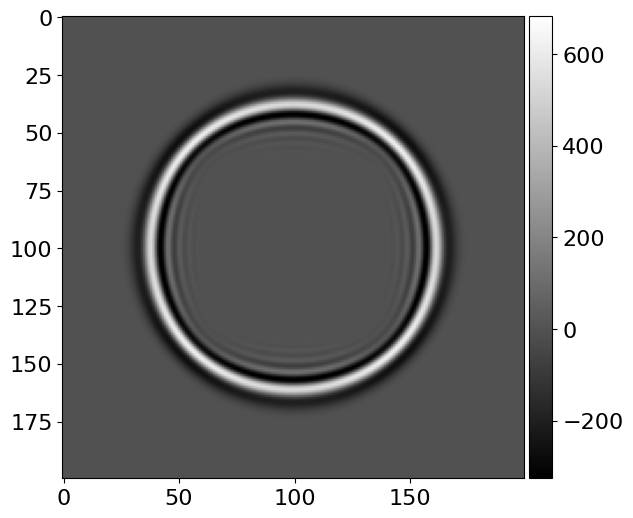

In [36]:
# showing output
plot_image(p_scaled.data[0])

## Checking that the scaling-rescaling process produces identical results to the unscaled process

Single precision generally allows around 7 decimal places, while half precision allows around 3/3.5. As a result of this, the relative/absolute tolerances are set at 3/4 decimal places in an attempt to account for differences that may be encountered when rounding from single to half precision.

In [37]:
# compare the output of the two simulations 
close_check = np.isclose(p.data, p_scaled.data, rtol=1e-3, atol=1e-4)

# check if all values are close
# if they are the same, should return Data(True)
all_close = np.all(close_check)
all_close

Data(False)